
# Developing Neural Network Models to Predict Trends in Dublin's Rental Property Market

This notebook is part of a thesis work aimed at developing neural network models, specifically Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) networks, to predict trends in Dublin's rental property market. The dataset used in this analysis is titled "RTB Average Monthly Rent Report" and contains rental data across various locations, property types, and years in Ireland.

Link: https://data.cso.ie/table/RIA02

### Dataset Overview
The dataset consists of the following columns:
- `STATISTIC Label`: Describes the statistical data (in this case, always "RTB Average Monthly Rent Report").
- `Year`: The year when the data was recorded.
- `Number of Bedrooms`: Number of bedrooms in the rental property.
- `Property Type`: The type of rental property.
- `Location`: The location of the property.
- `UNIT`: The unit of the rental value (Euro).
- `VALUE`: The average monthly rent in Euros.

The data includes 299,712 rows and 7 columns. It is important to note that the `VALUE` column contains missing values that need to be handled during data preprocessing.

# 1. Data 

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import warnings  # filter warnings
warnings.filterwarnings('ignore')

# Loading the dataset
df = pd.read_csv('RTB Average Monthly Rent Report.csv')
df.head()

STATISTIC Label  Year Number of Bedrooms  \
0  RTB Average Monthly Rent Report  2008       All bedrooms   
1  RTB Average Monthly Rent Report  2008       All bedrooms   
2  RTB Average Monthly Rent Report  2008       All bedrooms   
3  RTB Average Monthly Rent Report  2008       All bedrooms   
4  RTB Average Monthly Rent Report  2008       All bedrooms   

        Property Type               Location  UNIT   VALUE  
0  All property types                 Carlow  Euro  748.48  
1  All property types            Carlow Town  Euro  811.53  
2  All property types  Graiguecullen, Carlow  Euro  711.35  
3  All property types         Tullow, Carlow  Euro  720.04  
4  All property types                  Cavan  Euro  571.72

In [2]:
print(df.shape)

(299712, 7)


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   STATISTIC Label     299712 non-null  object 
 1   Year                299712 non-null  int64  
 2   Number of Bedrooms  299712 non-null  object 
 3   Property Type       299712 non-null  object 
 4   Location            299712 non-null  object 
 5   UNIT                299712 non-null  object 
 6   VALUE               104665 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 16.0+ MB
None


# 2. Exploratory Data Analysis

### Checking for missing values

In [4]:
## Missing Data Analysis

# Checking for missing values
missing_values = df.isnull().sum()
missing_values

STATISTIC Label            0
Year                       0
Number of Bedrooms         0
Property Type              0
Location                   0
UNIT                       0
VALUE                 195047
dtype: int64

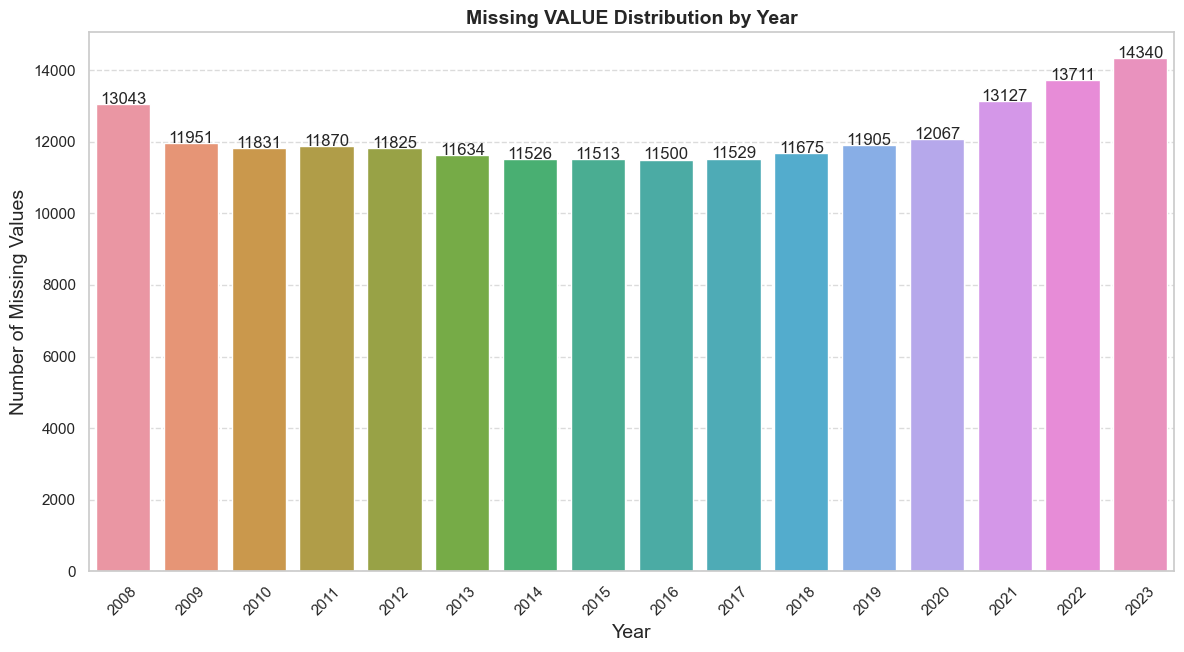

In [5]:
# Visualizing missing data distribution by Year with enhanced style
missing_distribution = df[df['VALUE'].isnull()]['Year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.barplot(x=missing_distribution.index, y=missing_distribution.values)

# Adding values on top of bars
for index, value in enumerate(missing_distribution.values):
    plt.text(index, value + 5, f'{value}', ha='center', fontsize=12)

plt.title('Missing VALUE Distribution by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [7]:
# Step 1: Impute missing values with the mean of each combination of Year and Location
df1['VALUE'] = df1.groupby(['Year', 'Location'])['VALUE'].transform(lambda x: x.fillna(x.mean()))

# Step 2: Check if there are still missing values after the first imputation
missing_after_first_step = df1['VALUE'].isnull().sum()
print(f"Missing values after imputing by Year and Location: {missing_after_first_step}")

# Step 3: If there are still missing values, impute with the annual mean (Year only)
df1['VALUE'] = df1.groupby('Year')['VALUE'].transform(lambda x: x.fillna(x.mean()))

# Step 4: Check if there are still missing values after imputing by year
missing_after_second_step = df1['VALUE'].isnull().sum()
print(f"Missing values after imputing by Year: {missing_after_second_step}")

# Step 5: If there are still missing values, fill with the overall median
if missing_after_second_step > 0:
    overall_median = df1['VALUE'].median()
    df1['VALUE'].fillna(overall_median, inplace=True)

# Final check to ensure all missing values have been imputed
missing_after_final_step = df1['VALUE'].isnull().sum()
print(f"Missing values after all imputations: {missing_after_final_step}")


Missing values after imputing by Year and Location: 0
Missing values after imputing by Year: 0
Missing values after all imputations: 0


### Checking for Infinite Values in a DataFrame

In [8]:
import numpy as np

# Replace infinite values with NaN temporarily to count them
def check_infinite_values(df):
    # Temporarily replace infinities with NaN
    inf_count = df.replace([np.inf, -np.inf], np.nan).isna().sum()
    
    # Filter out columns with no infinite values
    inf_count = inf_count[inf_count > 0]
    
    # Display the columns with infinite values and their respective counts
    if not inf_count.empty:
        print("Columns with infinite values and their counts:")
        print(inf_count)
    else:
        print("No infinite values found in the DataFrame.")

# Call the function to check for infinite values in df1
check_infinite_values(df1)


No infinite values found in the DataFrame.


###  Check for duplicate rows

In [11]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Optionally, display the duplicate rows
duplicates = df[df.duplicated()]
print(duplicates)

Number of duplicate rows: 0
Empty DataFrame
Columns: [STATISTIC Label, Year, Number of Bedrooms, Property Type, Location, UNIT, VALUE]
Index: []


In [12]:
# Check which rows have NaN in the 'VALUE' column
nan_rows = df1[df1['VALUE'].isna()]
print(nan_rows.head())  # Display the first few rows with NaN in 'VALUE'

Empty DataFrame
Columns: [STATISTIC Label, Year, Number of Bedrooms, Property Type, Location, UNIT, VALUE]
Index: []


### Detect outliers using the IQR method with adjusted multiplier

In [16]:
# Detect outliers using the IQR method with adjusted multiplier
def detect_outliers_iqr_adjusted(df1, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Find outliers
    outliers = df1[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers with multiplier {multiplier}: {len(outliers)}")
    
    # Return the bounds and outliers
    return outliers, lower_bound, upper_bound

# Apply the function and retain outliers
outliers_iqr_adjusted, lower_bound, upper_bound = detect_outliers_iqr_adjusted(df, 'VALUE', multiplier=3)

# Justify keeping high-value outliers
print(f"Outliers found above the upper bound ({upper_bound}) are justified as high-value properties and will be kept in the dataset.")

# Examples of high-value outliers
high_value_outliers = outliers_iqr_adjusted[outliers_iqr_adjusted['VALUE'] > upper_bound]
print("Examples of high-value outliers that will be retained:")
print(high_value_outliers.head(10))

# Final dataset including outliers, named as df2
df2 = df1.copy()

# Confirm the dataset is ready for further analysis
print("The dataset has been defined as df2 and is ready for further analysis.")


Number of outliers with multiplier 3: 304
Outliers found above the upper bound (3053.080000000001) are justified as high-value properties and will be kept in the dataset.
Examples of high-value outliers that will be retained:
                        STATISTIC Label  Year Number of Bedrooms  \
72352   RTB Average Monthly Rent Report  2011      Four plus bed   
74135   RTB Average Monthly Rent Report  2011      Four plus bed   
74136   RTB Average Monthly Rent Report  2011      Four plus bed   
91084   RTB Average Monthly Rent Report  2012      Four plus bed   
92633   RTB Average Monthly Rent Report  2012      Four plus bed   
92867   RTB Average Monthly Rent Report  2012      Four plus bed   
92868   RTB Average Monthly Rent Report  2012      Four plus bed   
109816  RTB Average Monthly Rent Report  2013      Four plus bed   
111600  RTB Average Monthly Rent Report  2013      Four plus bed   
114203  RTB Average Monthly Rent Report  2014       All bedrooms   

             Property Typ

### Visualize the outliers in the context of time (by year)

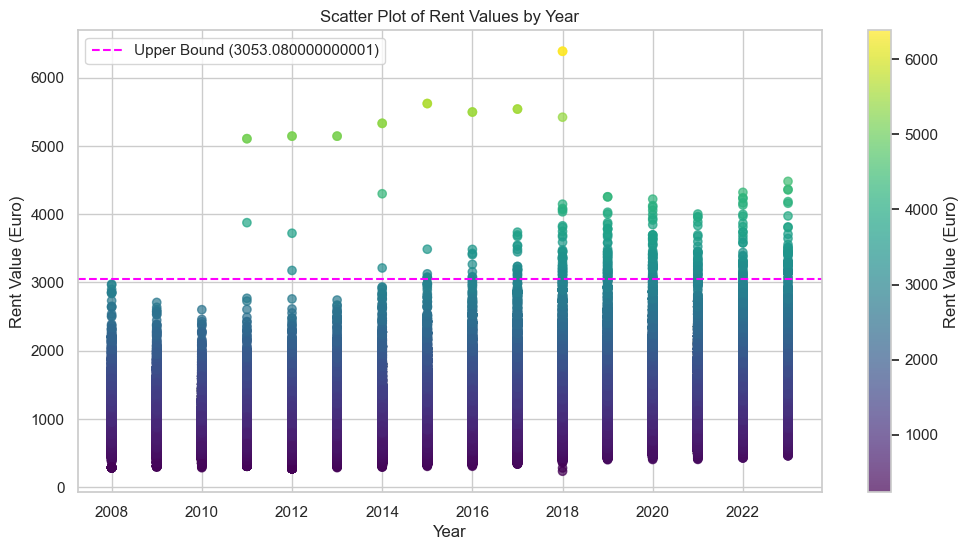

In [17]:
import numpy as np

plt.figure(figsize=(12, 6))

# Use a colormap for more colorful points based on the rent value
scatter = plt.scatter(df2['Year'], df2['VALUE'], c=df2['VALUE'], cmap='viridis', alpha=0.7)

# Add a color bar for reference
plt.colorbar(scatter, label='Rent Value (Euro)')

# Titles and labels
plt.title('Scatter Plot of Rent Values by Year')
plt.xlabel('Year')
plt.ylabel('Rent Value (Euro)')

# Highlight the upper bound for outliers
plt.axhline(y=upper_bound, color='magenta', linestyle='--', label=f'Upper Bound ({upper_bound})')

plt.legend()
plt.show()

## 3. Data Visualization

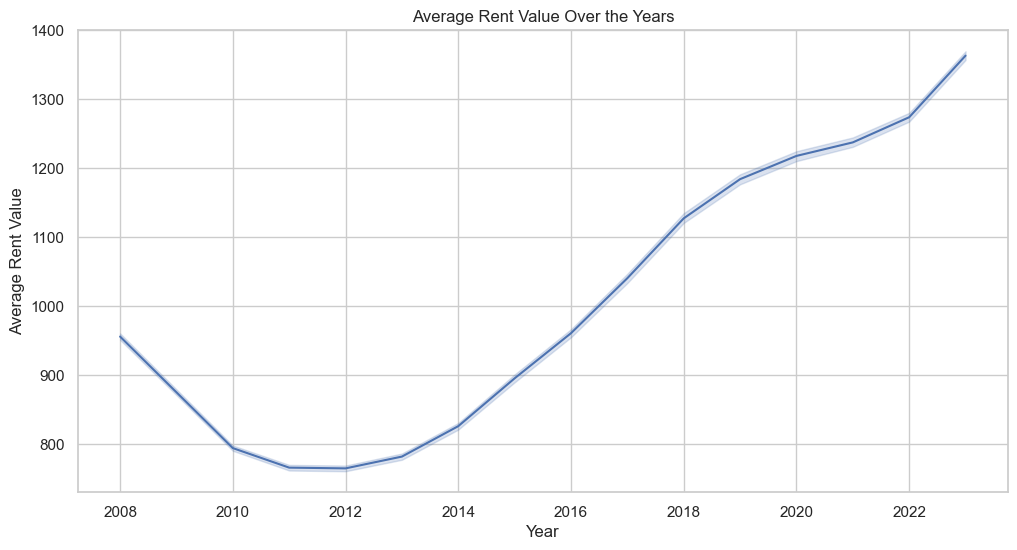

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trends over Years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x='Year', y='VALUE')
plt.title('Average Rent Value Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Rent Value')
plt.grid(True)
plt.show()

### Rent Values by Top 10 Locations

In [14]:
import plotly.express as px

# Rent Values by Top 10 Locations
top_locations = df1['Location'].value_counts().nlargest(10).index
filtered_data = df1[df1['Location'].isin(top_locations)]
fig = px.box(filtered_data, x='Location', y='VALUE', color='Location', title='Rent Values by Top 10 Locations')
fig.update_xaxes(categoryorder='total descending')
fig.show()

### Identify the top cities

In [18]:
# Identify the top cities (excluding Dublin)
top_cities = df1['Location'].value_counts().head(6).index  # Select the 6 most frequent cities
top_cities = top_cities[top_cities.str.contains('Dublin', case=False) == False]  # Exclude Dublin

# Add Dublin to the list of cities for comparison
top_cities = top_cities.insert(0, 'Dublin')

### Histograms for Dublin and the selected cities

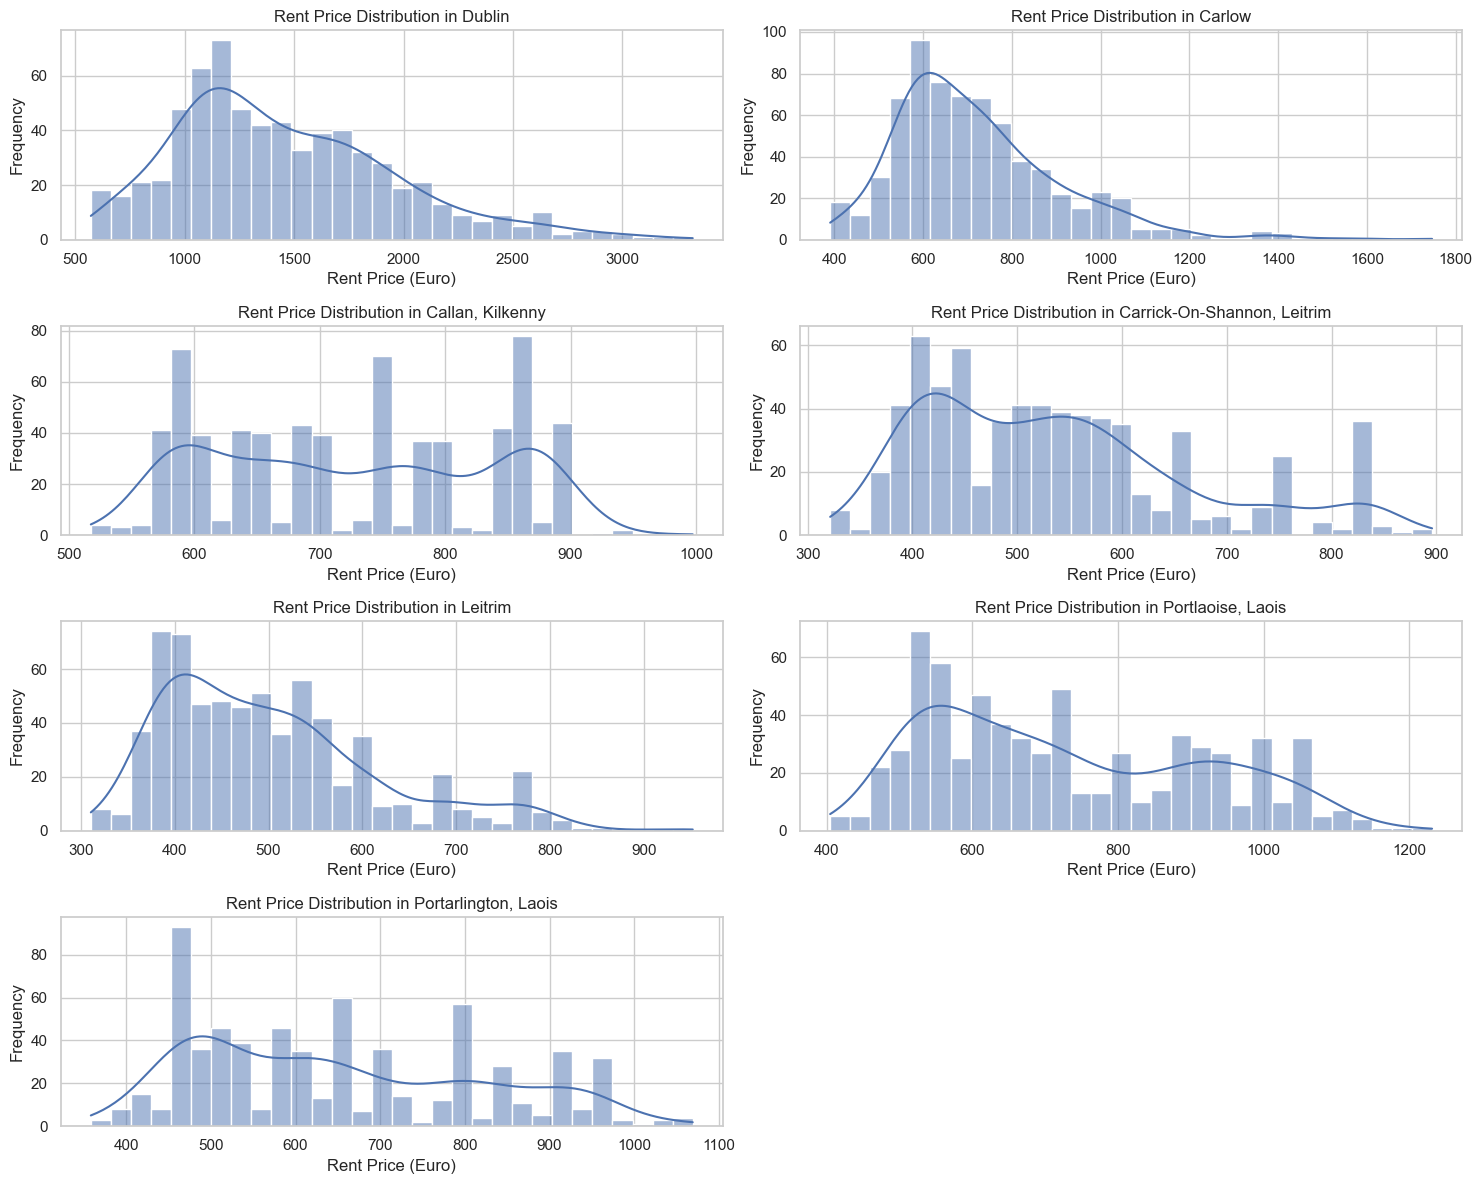

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame to include only the selected cities
df_cities = df1[df1['Location'].isin(top_cities)]

# Plot histograms for Dublin and the selected cities
plt.figure(figsize=(15, 12))

for i, city in enumerate(top_cities):
    plt.subplot(4, 2, i + 1)  # Adjust the grid size based on the number of cities
    sns.histplot(df_cities[df_cities['Location'] == city]['VALUE'], kde=True, bins=30)
    plt.title(f'Rent Price Distribution in {city}')
    plt.xlabel('Rent Price (Euro)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Average Monthly Rent by Number of Bedrooms

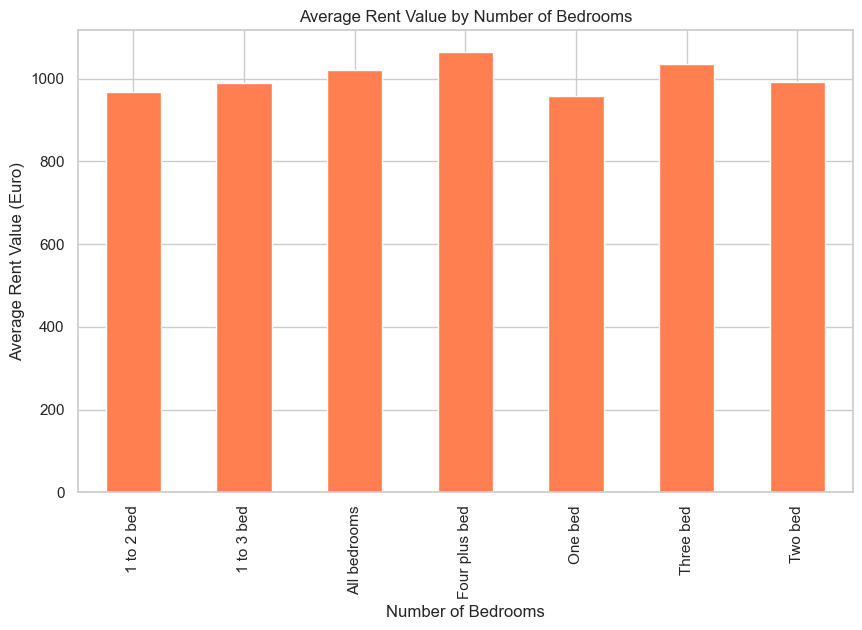

In [21]:
plt.figure(figsize=(10, 6))
df1.groupby('Number of Bedrooms')['VALUE'].mean().plot(kind='bar', color='coral')
plt.title('Average Rent Value by Number of Bedrooms')
plt.ylabel('Average Rent Value (Euro)')
plt.show()


# Dublin 

In [22]:
# Filter for rows where 'Location' contains 'Dublin' to create df2
df2 = df1[df1['Location'].str.contains('Dublin', case=False, na=False)]

# Show the first few rows of df2 to confirm the filtering
print(df2.head())

# Save df2 for future analysis and predictions
df2.to_csv('dublin_rental_data.csv', index=False)

print("Filtered dataset for Dublin saved as 'dublin_rental_data.csv'.")

                    STATISTIC Label  Year Number of Bedrooms  \
71  RTB Average Monthly Rent Report  2008       All bedrooms   
72  RTB Average Monthly Rent Report  2008       All bedrooms   
73  RTB Average Monthly Rent Report  2008       All bedrooms   
74  RTB Average Monthly Rent Report  2008       All bedrooms   
75  RTB Average Monthly Rent Report  2008       All bedrooms   

         Property Type             Location  UNIT        VALUE  
71  All property types               Dublin  Euro  1271.310000  
72  All property types   Balbriggan, Dublin  Euro  1033.330000  
73  All property types    Blackrock, Dublin  Euro  1587.100000  
74  All property types  Booterstown, Dublin  Euro  1656.820000  
75  All property types   Cabinteely, Dublin  Euro   955.819531  
Filtered dataset for Dublin saved as 'dublin_rental_data.csv'.


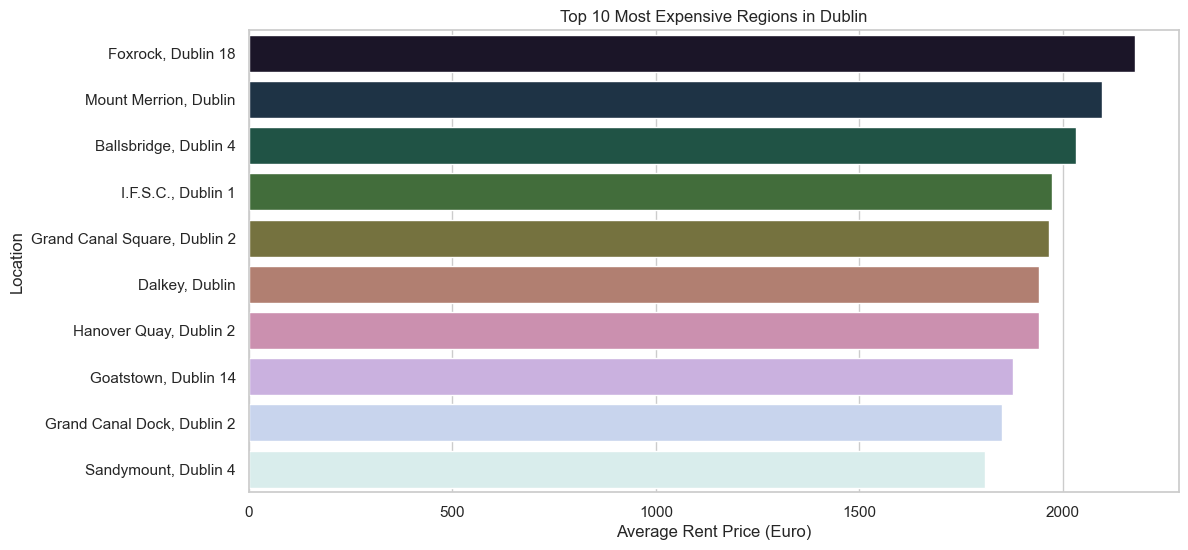

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean rent price per location in Dublin (using df2)
mean_rent_per_location = df2.groupby('Location')['VALUE'].mean().sort_values(ascending=False)

# Select the top 10 most expensive regions
top_10_expensive_locations = mean_rent_per_location.head(10)

# Plotting the top 10 most expensive locations with 'cubehelix' color palette
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_expensive_locations.values, y=top_10_expensive_locations.index, palette='cubehelix')
plt.title('Top 10 Most Expensive Regions in Dublin')
plt.xlabel('Average Rent Price (Euro)')
plt.ylabel('Location')
plt.show()


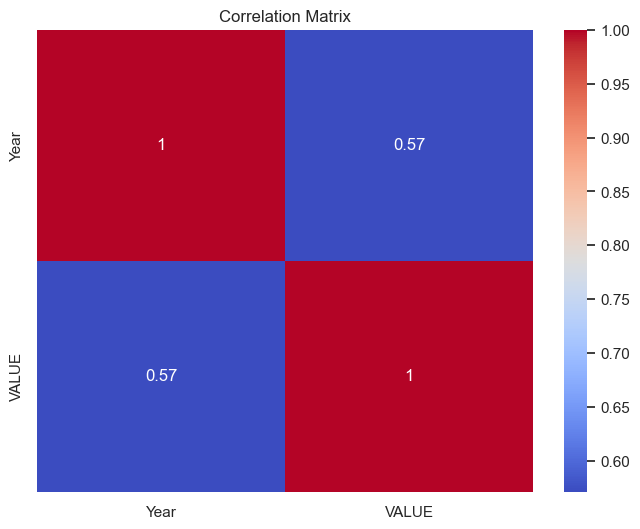

In [27]:
# Correlation matrix
corr_matrix = df2.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

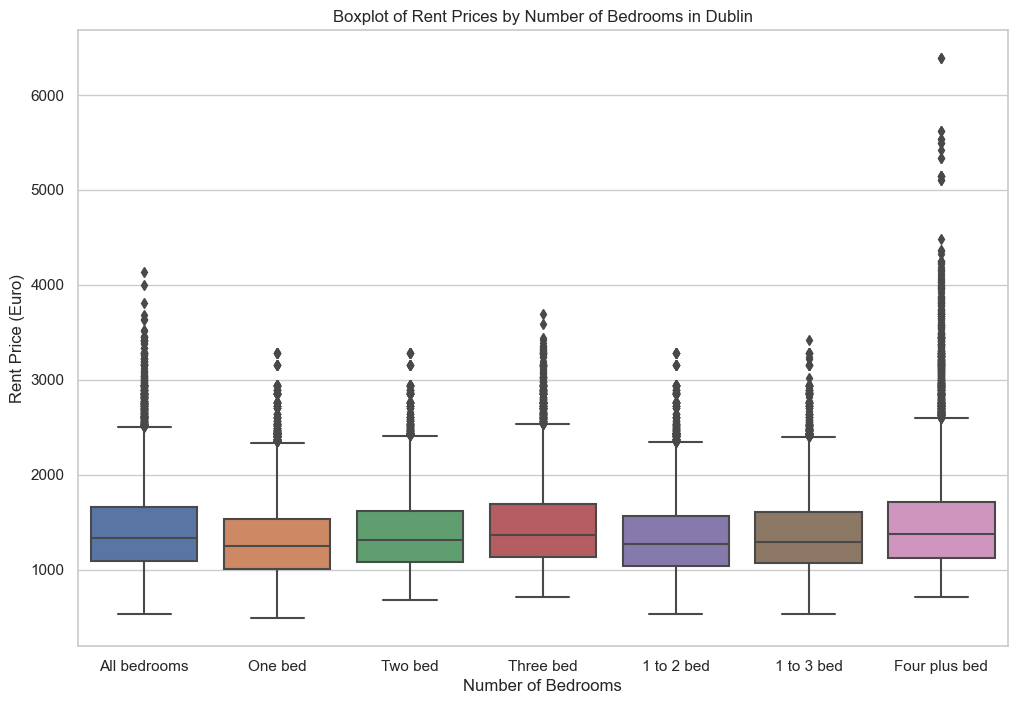

In [28]:
# Boxplot to detect outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df2, x='Number of Bedrooms', y='VALUE')
plt.title('Boxplot of Rent Prices by Number of Bedrooms in Dublin')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Rent Price (Euro)')
plt.show()

### Dublin's Outliers

In [29]:
# No outlier removal: Keeping all the data for analysis, including high rent prices
# df2 = df2[(df2['VALUE'] >= Q1 - 1.5 * IQR) & (df2['VALUE'] <= Q3 + 1.5 * IQR)]

# Proceed with the analysis including all rent prices
df2.describe()

Year          VALUE
count  112224.000000  112224.000000
mean     2015.500000    1387.048530
std         4.609793     420.533323
min      2008.000000     488.130000
25%      2011.750000    1079.152727
50%      2015.500000    1315.876667
75%      2019.250000    1627.601739
max      2023.000000    6385.740000

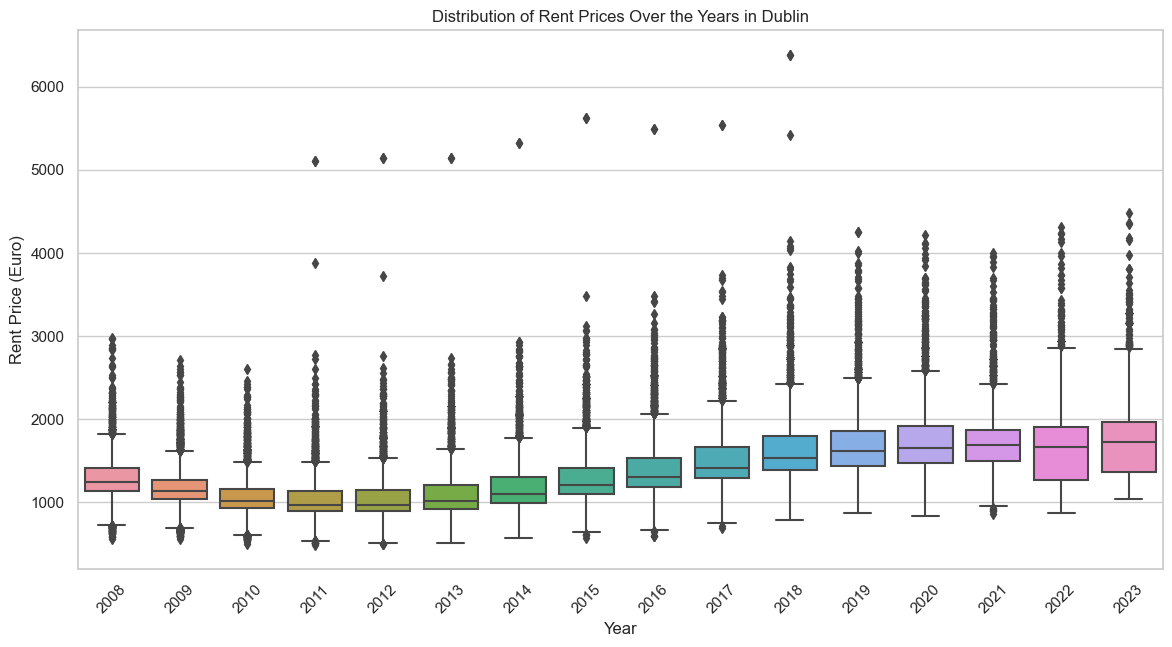

In [30]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='Year', y='VALUE', data=df2)
plt.title('Distribution of Rent Prices Over the Years in Dublin')
plt.xlabel('Year')
plt.ylabel('Rent Price (Euro)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Dickey-Fuller test

In [39]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(df2['VALUE'].dropna())

# Extract and display results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')



ADF Statistic: -9.70913351962796
p-value: 1.0227134670109034e-16
Critical Value (1%): -3.4304083082902537
Critical Value (5%): -2.861565771381552
Critical Value (10%): -2.566783717199238


### Autocorrelation (ACF) and Partial Autocorrelation (PACF) Correlation Test

<Figure size 1000x600 with 0 Axes>

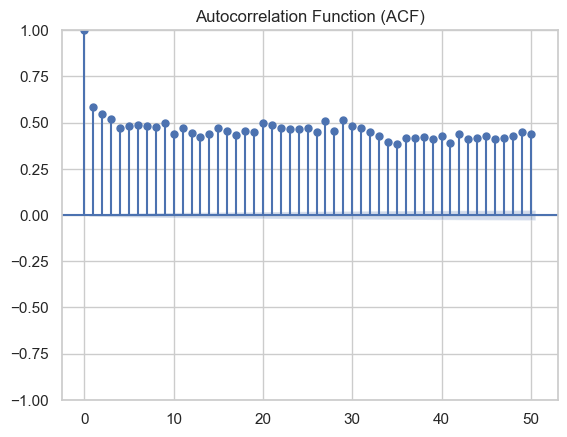

<Figure size 1000x600 with 0 Axes>

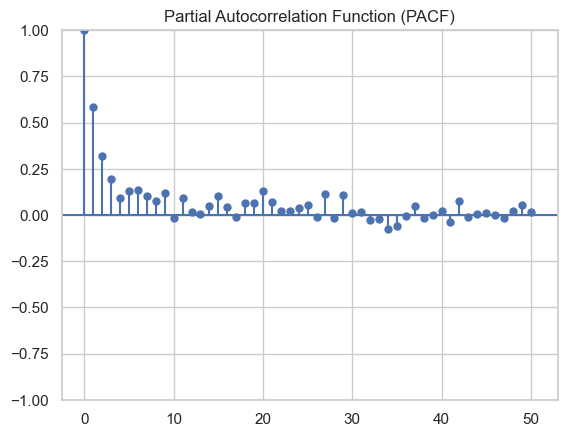

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(10, 6))
plot_acf(df2['VALUE'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plt.figure(figsize=(10, 6))
plot_pacf(df2['VALUE'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


### 2. Spearman correlation

In [44]:
# Spearman correlation between Year and Rent Value
spearman_corr, p_value = stats.spearmanr(df2['Year'], df2['VALUE'])

print('Spearman correlation between Year and Rent Value:', spearman_corr)
print('P-value:', p_value)


Spearman correlation between Year and Rent Value: 0.6209940266823573
P-value: 0.0


### 3. Heteroscedasticity Test (Breusch-Pagan Test)
For time series data, it is important to verify if the variance is constant over time. Heteroscedasticity occurs when the variance changes over time, which can complicate modeling.

Code for the Breusch-Pagan test:

In [47]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols

# Simple regression for the test
model = ols('VALUE ~ Year', data=df2).fit()
test_result = het_breuschpagan(model.resid, model.model.exog)

# Display results
print('Breusch-Pagan Test Statistic:', test_result[0])
print('p-value:', test_result[1])


Breusch-Pagan Test Statistic: 614.3277796072759
p-value: 1.2807180020420195e-135


In [46]:
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test for normality
stat, p_value = shapiro(df2['VALUE'].dropna())

print('Shapiro-Wilk Statistic:', stat)
print('p-value:', p_value)


Shapiro-Wilk Statistic: 0.938151478767395
p-value: 0.0


1. Stationarity Test - ADF (Augmented Dickey-Fuller)
Result:

ADF Statistic: -9.7091
p-value: 1.0227134670109034e-16
Critical Values:
1%: -3.4304
5%: -2.8615
10%: -2.5667
Interpretation:

Since the p-value is extremely low (less than 0.05), we can reject the null hypothesis that the series is non-stationary.
The series is stationary, meaning its properties, such as mean and variance, do not change significantly over time. This is a good sign for time series modeling, as stationarity is generally a prerequisite for accurate forecasting.
2. ACF (Autocorrelation) and PACF (Partial Autocorrelation) Plots
ACF: Shows strong correlations across many lags, indicating long-term persistence in the series.
PACF: Shows a clear cutoff after the second lag, suggesting that short-term dependencies (lag 1 or 2) may be enough to capture the temporal relationships.
Interpretation:

Based on the PACF plot, it may be appropriate to consider the first two lags when training time series models such as RNN or LSTM.
The ACF indicates long-term correlation, suggesting that past values influence future predictions.
3. Spearman Correlation
Result:

Spearman Correlation between Year and VALUE: 0.6209
p-value: 0.0
Interpretation:

The Spearman correlation is moderate (0.62), indicating a positive relationship between the year and rental prices. In other words, as the years progress, there is a consistent increase in rental prices.
The p-value of 0.0 confirms that this correlation is statistically significant.
4. Heteroscedasticity Test - Breusch-Pagan
Result:

Breusch-Pagan Test Statistic: 614.327
p-value: 1.2807180020420195e-135
Interpretation:

The extremely low p-value suggests the presence of heteroscedasticity in the data. This means that the variance of rental prices is not constant over time.
In models like RNN or LSTM, heteroscedasticity can affect prediction accuracy. Depending on the case, it may be necessary to apply transformations to adjust the data (e.g., log-transformation or differencing).
5. Normality Test - Shapiro-Wilk
Result:

Shapiro-Wilk Statistic: 0.9381
p-value: 0.0
Interpretation:

The p-value of 0.0 indicates that the data does not follow a normal distribution. While this is not a critical issue for models like RNN and LSTM, which do not assume normality of data, it is important to be aware of this when interpreting results.


# 5. Feature Engineering and Data Preparation

In [49]:
import numpy as np

# Step 1: Drop all columns except 'Year' and 'VALUE'
df3 = df2[['Year', 'VALUE']].copy()

# Display the first few rows to confirm
print(df3.head())

# Step 2: Apply log transformation to stabilize variance (optional)
df3['log_VALUE'] = np.log(df3['VALUE'])

# Display the first few rows to confirm the log transformation
print(df3.head())

# Step 3: Create lag features based on PACF (lags 1 and 2)
df3['lag1'] = df3['VALUE'].shift(1)
df3['lag2'] = df3['VALUE'].shift(2)

# Remove rows with NaN values introduced by shifting (due to lag creation)
df3 = df3.dropna()

# Display the first few rows to confirm the final dataset
print(df3.head())

    Year        VALUE
71  2008  1271.310000
72  2008  1033.330000
73  2008  1587.100000
74  2008  1656.820000
75  2008   955.819531
    Year        VALUE  log_VALUE
71  2008  1271.310000   7.147803
72  2008  1033.330000   6.940542
73  2008  1587.100000   7.369664
74  2008  1656.820000   7.412655
75  2008   955.819531   6.862569
    Year        VALUE  log_VALUE         lag1         lag2
73  2008  1587.100000   7.369664  1033.330000  1271.310000
74  2008  1656.820000   7.412655  1587.100000  1033.330000
75  2008   955.819531   6.862569  1656.820000  1587.100000
76  2008   955.819531   6.862569   955.819531  1656.820000
77  2008  1655.470000   7.411840   955.819531   955.819531


Column Selection: We started by filtering the dataset, keeping only the relevant columns, Year and VALUE, as these are the main variables of interest for our time series analysis. This step ensured that only the essential information is retained for modeling.

Log Transformation: To handle heteroscedasticity (as detected by the Breusch-Pagan test), we applied a log transformation to the VALUE column, creating a new column called log_VALUE. This transformation helps to stabilize the variance over time, making the series more suitable for time series models like RNN and LSTM.

Lag Feature Creation: Based on the PACF analysis, we identified that the first two lags (lag 1 and lag 2) could provide useful information for capturing temporal dependencies in the data. Therefore, we created lagged features for these two previous time points. This will allow the model to incorporate past values into its predictions.

Handling Missing Values: Since the creation of lag features introduces NaN values in the first few rows (due to the shifting process), we removed these rows to ensure the dataset is clean and ready for model training.

Final Prepared Dataset:
The final dataset, df3, includes the following columns:

Year: The year of observation.
VALUE: The original rent values.
log_VALUE: The log-transformed rent values (optional, based on the decision to handle heteroscedasticity).
lag1 and lag2: The first and second lag values of rent, capturing past trends for predictive modeling.

## Divisão dos Dados e Preparação para RNN/LSTM
Agora que temos o df3 preparado, com as colunas relevantes (ano, valor, log-transformação opcional, e lags), o próximo passo é dividir os dados em conjunto de treinamento e teste e preparar o dataset para ser alimentado no modelo RNN ou LSTM.

Aqui está o que faremos:

Passo 1: Divisão do Conjunto de Dados (Train/Test Split)
Dividiremos os dados em duas partes:

Conjunto de Treinamento (para treinar o modelo).
Conjunto de Teste (para avaliar o desempenho do modelo).
Como estamos trabalhando com uma série temporal, é importante preservar a ordem temporal dos dados ao fazer a divisão. O método comum é utilizar as primeiras X% das observações para treino e as últimas Y% para teste.

Passo 2: Normalização dos Dados
Modelos como RNN e LSTM se beneficiam da normalização (ou padronização) dos dados, especialmente quando as variáveis têm diferentes escalas ou distribuições. Vamos aplicar Min-Max Scaling para escalar os valores entre 0 e 1, o que pode ajudar o modelo a convergir mais rapidamente.

Código para Divisão e Normalização:


## Preparação dos Dados para RNN

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Step 1: Select features (lag1, lag2) and target (VALUE or log_VALUE)
features = ['lag1', 'lag2']
target = 'VALUE'  

# Step 2: Drop any remaining NaN values
df3.dropna(inplace=True)

# Step 3: Split the data into train and test sets (80% train, 20% test)
train_size = int(len(df3) * 0.8)
train, test = df3.iloc[:train_size], df3.iloc[train_size:]

# Step 4: Normalize the data (Min-Max Scaling)
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test sets
train_scaled = scaler.fit_transform(train[features + [target]])
test_scaled = scaler.transform(test[features + [target]])

# Prepare the data for RNN model
# Separating features and target
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]  # Features and target for train
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]  # Features and target for test

# Reshape data for RNN (3D structure required: [samples, time steps, features])
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Display shapes to confirm everything is ready for model input
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (89777, 1, 2)
y_train shape: (89777,)
X_test shape: (22445, 1, 2)
y_test shape: (22445,)


## Passo 1: Construção da Rede Neural Recorrente (RNN)
Vamos configurar um modelo RNN simples usando Keras (uma biblioteca popular para redes neurais que faz parte do TensorFlow). Nosso modelo terá uma camada RNN simples e uma camada densa (fully connected) para gerar as previsões.

Passo 2: Compilação e Treinamento
Vamos compilar o modelo usando uma função de perda adequada e um otimizador, e depois treiná-lo usando o conjunto de treino que acabamos de preparar.

Código para Construção e Treinamento do RNN:

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Step 1: Add more lags (lag1 to lag5)
df3['lag3'] = df3['VALUE'].shift(3)
df3['lag4'] = df3['VALUE'].shift(4)
df3['lag5'] = df3['VALUE'].shift(5)

# Drop NaN values caused by the shift
df3.dropna(inplace=True)

# Step 2: Select features and target
features = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5']
target = 'VALUE'  # You can also use 'log_VALUE' if using the log-transformed values

# Normalize the data
scaler = MinMaxScaler()

# Split the data into train and test sets
train_size = int(len(df3) * 0.8)
train, test = df3.iloc[:train_size], df3.iloc[train_size:]

# Scale the data
train_scaled = scaler.fit_transform(train[features + [target]])
test_scaled = scaler.transform(test[features + [target]])

# Step 3: Prepare the data for RNN
# Separate features and target
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]  # Features and target for train
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]  # Features and target for test

# Reshape the data for RNN: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Now input shape will be [None, 1, 5]
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Adjust for test set as well

# Display shapes to confirm
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Step 4: Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=100, activation='relu', input_shape=(1, 5)))  # 1 time step, 5 features
model.add(Dense(1))

# Step 5: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Implement Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Step 7: Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


X_train shape: (89757, 1, 5)
X_test shape: (22440, 1, 5)
Epoch 1/50
2805/2805 [==============================] - 6s 2ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 2/50
2805/2805 [==============================] - 5s 2ms/step - loss: 0.0022 - val_loss: 0.0048
Epoch 3/50
2805/2805 [==============================] - 5s 2ms/step - loss: 0.0022 - val_loss: 0.0048
Epoch 4/50
2805/2805 [==============================] - 6s 2ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 5/50
2805/2805 [==============================] - 6s 2ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 6/50
2805/2805 [==============================] - 6s 2ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 7/50
2805/2805 [==============================] - 7s 2ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 8/50
2805/2805 [==============================] - 7s 2ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 9/50
2805/2805 [==============================] - 7s 2ms/step - loss: 0.0020 - val_loss: 0.0050
Epoch 10/50
2805/2805 [==

### Explicação:
Modelo RNN:
Passo 1: Adicionar Mais Lags
python
Copiar código
df3['lag3'] = df3['VALUE'].shift(3)
df3['lag4'] = df3['VALUE'].shift(4)
df3['lag5'] = df3['VALUE'].shift(5)

df3.dropna(inplace=True)
O que foi feito:
Adicionamos mais lags: Além de lag1 e lag2, que já tínhamos, adicionamos lag3, lag4, e lag5. Isso significa que, para cada observação no dataset, estamos agora incluindo os valores de aluguel dos 5 períodos anteriores como features de entrada para o modelo.
Remoção de valores NaN: As primeiras linhas do dataset ficam com valores NaN por causa da criação dos lags (as primeiras observações não têm os valores anteriores para preencher os lags), então removemos essas linhas usando dropna().
Passo 2: Seleção de Features e Target
python
Copiar código
features = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5']
target = 'VALUE'  # You can also use 'log_VALUE' if using the log-transformed values
O que foi feito:
Definimos as features: As colunas de lags (lag1 a lag5) são as features que serão usadas como entradas no modelo. Essas colunas representam os valores de aluguel dos 5 períodos anteriores.
Definimos o alvo (target): A coluna VALUE é o que estamos tentando prever, ou seja, o valor de aluguel atual.
Passo 3: Normalização e Divisão dos Dados
python
Copiar código
scaler = MinMaxScaler()

train_size = int(len(df3) * 0.8)
train, test = df3.iloc[:train_size], df3.iloc[train_size:]

train_scaled = scaler.fit_transform(train[features + [target]])
test_scaled = scaler.transform(test[features + [target]])
O que foi feito:
Normalização dos dados: Utilizamos o MinMaxScaler para normalizar os dados de entrada entre 0 e 1. A normalização é importante para modelos como RNN, pois ajuda a evitar problemas com grandes variações nos valores.
Divisão em treino e teste: Dividimos os dados em 80% para treino e 20% para teste. Isso nos permite treinar o modelo em um conjunto de dados e testar o desempenho em dados que ele não viu antes.
Passo 4: Preparação para o RNN (Reshape dos Dados)
python
Copiar código
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
O que foi feito:
Separação de features e target: Estamos separando as features (lag1 a lag5) e o alvo (VALUE) para os conjuntos de treino e teste.
X_train e X_test: As features (colunas de lag).
y_train e y_test: O valor real de aluguel (o que estamos tentando prever).
Reshape para RNN: O modelo RNN espera dados de entrada no formato 3D, ou seja, [samples, time steps, features]. Aqui, usamos 1 time step e 5 features, então o reshape converte os dados para esse formato esperado. Isso informa ao modelo que estamos usando apenas um período de tempo (1 time step) e que temos 5 features (os lags).
Passo 5: Definição e Compilação do Modelo
python
Copiar código
model = Sequential()
model.add(SimpleRNN(units=100, activation='relu', input_shape=(1, 5)))  # 1 time step, 5 features
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
O que foi feito:
Criação do Modelo: Definimos um modelo RNN simples usando a classe Sequential do Keras.
SimpleRNN: Adicionamos uma camada RNN com 100 unidades (neurônios) e função de ativação ReLU. A entrada para a camada é especificada como (1, 5), ou seja, 1 time step e 5 features (os lags que criamos).
Dense: Adicionamos uma camada densa com 1 unidade de saída, pois estamos prevendo um único valor (o valor de aluguel atual).
Compilação: Compilamos o modelo usando o otimizador Adam e a função de perda Mean Squared Error (MSE), que é comum para problemas de regressão.
Passo 6: Treinamento do Modelo
python
Copiar código
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
O que foi feito:
Treinamento do Modelo: O modelo é treinado por 50 épocas usando um batch size de 32. Durante o treinamento, o modelo também valida seu desempenho no conjunto de teste, o que nos permite acompanhar a evolução tanto no treino quanto no teste.
Passo 7: Avaliação do Modelo
python
Copiar código
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
O que foi feito:
Avaliação do Modelo: Avaliamos o desempenho do modelo no conjunto de teste e exibimos a perda final (MSE) após o treinamento.
Resumo:
O código atualizou o número de lags para incluir lag3, lag4 e lag5, totalizando 5 lags como entrada para o modelo.
Ajustamos o reshape dos dados para refletir 5 features e garantir que o modelo receba os dados no formato correto.
O modelo RNN foi expandido para 100 unidades e treinado por 50 épocas para capturar melhor os padrões da série temporal.

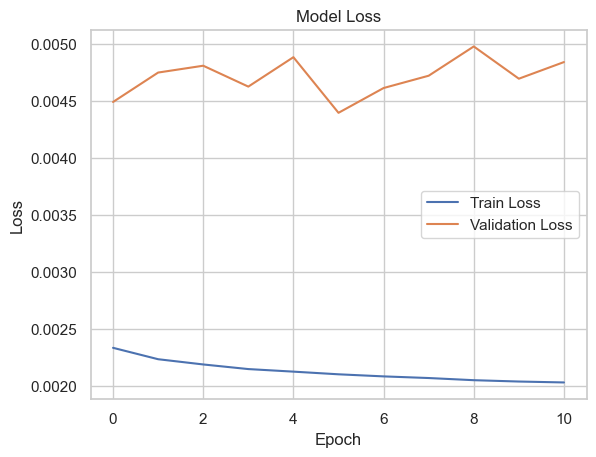

In [64]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

702/702 [==============================] - 1s 1ms/step
RMSE: 391.1176376253178
MAE: 294.8413824319897


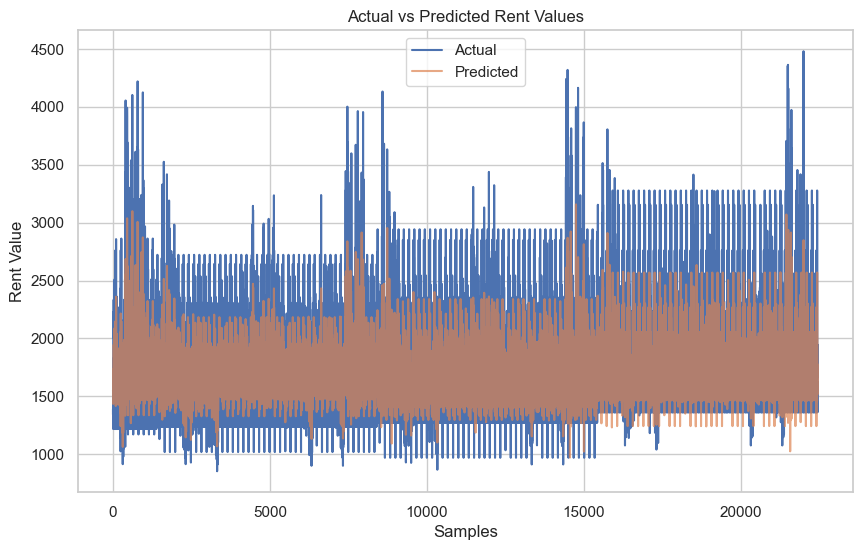

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Generate predictions for the test set
y_pred = model.predict(X_test)

# Step 2: Rescale the predictions and the actual values back to the original range
# Rescale predictions and actual values
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :5].reshape(X_test.shape[0], 5), y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :5].reshape(X_test.shape[0], 5), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Step 3: Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Step 4: Visualize the predictions vs actual values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Rent Values')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()


## Explorar o uso de uma camada adicional ou LSTM: Vamos adicionar uma camada adicional ou usar LSTM, uma arquitetura mais avançada que pode ajudar a capturar padrões temporais com mais eficiência.

In [71]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from scikeras.wrappers import KerasRegressor  # Import from SciKeras
import numpy as np

# Step 1: Add more lags (lag1 to lag5)
df3['lag3'] = df3['VALUE'].shift(3)
df3['lag4'] = df3['VALUE'].shift(4)
df3['lag5'] = df3['VALUE'].shift(5)

# Drop NaN values caused by the shift
df3.dropna(inplace=True)

# Step 2: Select features and target
features = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5']
target = 'VALUE'

# Normalize the data
scaler = MinMaxScaler()

# Split the data into train and test sets
train_size = int(len(df3) * 0.8)
train, test = df3.iloc[:train_size], df3.iloc[train_size:]

# Scale the data
train_scaled = scaler.fit_transform(train[features + [target]])
test_scaled = scaler.transform(test[features + [target]])

# Step 3: Prepare the data for RNN
# Separate features and target
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]

# Reshape the data for RNN: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Display shapes to confirm
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Step 4: Define the RNN model creation function
def build_rnn_model(units=100, activation='relu'):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=(1, 5)))  # 1 time step, 5 features
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 5: Wrap the Keras model for use with scikit-learn
rnn = KerasRegressor(model=build_rnn_model, epochs=100, batch_size=32, verbose=1)

# Step 6: Define hyperparameters to search
param_grid = {
    'model__units': [50, 100, 200],  # Number of RNN units
    'model__activation': ['relu', 'tanh'],  # Activation function
    'batch_size': [16, 32, 64],  # Batch size
    'epochs': [50, 100]  # Number of epochs
}

# Step 7: Implement Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 8: Perform Grid Search
grid = GridSearchCV(estimator=rnn, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stop])

# Step 9: Summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Step 10: Evaluate the model on the test data
test_loss = grid_result.best_estimator_.model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Optionally, you can save the best model
best_model = grid_result.best_estimator_.model
best_model.save('best_rnn_model.h5')

X_train shape: (89753, 1, 5)
X_test shape: (22439, 1, 5)


2024-09-16 17:57:17.274213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 17:57:17.293991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 17:57:17.338466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
3740/3740 [==============================] - 40s 10ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 2/50
3740/3740 [==============================] - 40s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 2/50
3740/3740 [==============================] - 40s 10ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 2/50
3740/3740 [==============================] - 41s 10ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 2/50
3740/3740 [==============================] - 41s 10ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 2/50
3740/3740 [==============================] - 43s 11ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 2/50
3740/3740 [==============================] - 40s 11ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 3/50
3740/3740 [==============================] - 40s 11ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 3/50
3740/3740 [==============================] - 40s 11ms/step - loss: 0.0027 - val_

In [68]:
# Step 8: Generate predictions and compare with actual values
y_pred = model.predict(X_test)

# Rescale the predictions and actual values back to original range
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :1].reshape(X_test.shape[0], 1), y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :1].reshape(X_test.shape[0], 1), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

702/702 [==============================] - 1s 1ms/step
RMSE: 390.80903061450823
MAE: 296.8137713816572


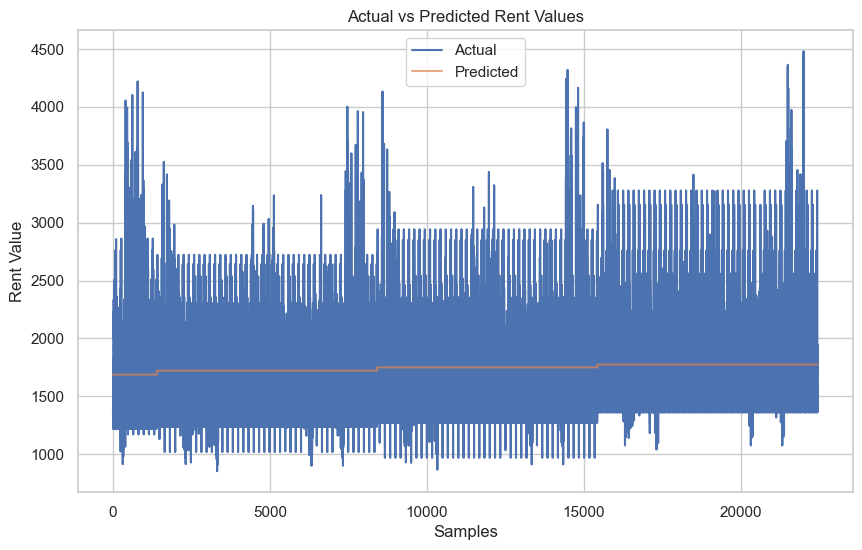

In [69]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Rent Values')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()